In [37]:
# STEP 1 — Imports & basic settings
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
import joblib

print("\nStarting Heart Disease pipeline...\n")



Starting Heart Disease pipeline...



In [39]:
# STEP 2 — Load dataset (edit path if needed)
DATA_PATH = '/content/Heart_Disease_Prediction.csv'  # change if needed
if not os.path.exists(DATA_PATH):
    # fallback to local filename
    DATA_PATH = 'Heart_Disease_Prediction.csv'

df = pd.read_csv(DATA_PATH)
print(f"Loaded: {DATA_PATH} -> shape = {df.shape}")


Loaded: /content/Heart_Disease_Prediction.csv -> shape = (270, 14)


In [40]:
# STEP 3 — Quick sanity checks and clean column names (strip whitespace)
df.columns = df.columns.str.strip()
print("\nColumns:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())



Columns:
['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']

First 5 rows:
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121          

In [41]:
# STEP 4 — Target mapping (robust)
target_col = 'Heart Disease'
if df[target_col].dtype == object:
    df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({'absence': 0, 'presence': 1})

# If mapping left NaNs (maybe target already numeric), try converting to int safely
if df[target_col].isnull().any():
    try:
        df[target_col] = pd.to_numeric(df[target_col])
    except:
        pass

print(f"\nTarget value counts:\n{df[target_col].value_counts(dropna=False)}")



Target value counts:
Heart Disease
0    150
1    120
Name: count, dtype: int64


In [44]:
# STEP 5 — Missing values handling
print("\nMissing values per column:")
print(df.isnull().sum())

# Impute numeric columns with median, categorical (object) with mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Remove target from imputation lists if present
if target_col in num_cols:
    num_cols.remove(target_col)
if target_col in cat_cols:
    cat_cols.remove(target_col)

num_imputer = SimpleImputer(strategy='median')
if len(num_cols) > 0:
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

if len(cat_cols) > 0: # Add check for empty cat_cols
    for c in cat_cols:
        df[c] = df[c].fillna(df[c].mode().iloc[0]) # Corrected indentation

print("\nPost-imputation missing values (should be 0):")
print(df.isnull().sum())


Missing values per column:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Post-imputation missing values (should be 0):
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64


In [46]:
# STEP 6 — Feature engineering (Age_Group, Cholesterol_Risk, BP_Risk)
# (makes bins and keeps them as integers 0..)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 40, 50, 60, 70, 200], labels=[0, 1, 2, 3, 4]).astype(int)
df['Cholesterol_Risk'] = pd.cut(df['Cholesterol'], bins=[0, 200, 239, 1e6], labels=[0, 1, 2]).astype(int)
df['BP_Risk'] = pd.cut(df['BP'], bins=[0, 120, 139, 159, 1e6], labels=[0, 1, 2, 3]).astype(int)



In [47]:
# STEP 7 — Select features (edit this list if your column names differ)
features = [
    'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
    'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
    'Slope of ST', 'Number of vessels fluro', 'Thallium',
    'Age_Group', 'Cholesterol_Risk', 'BP_Risk'
]

# Confirm all features exist in df
missing_features = [f for f in features if f not in df.columns]
if missing_features:

  raise ValueError(f"Missing expected feature columns in dataset: {missing_features}")

X = df[features].copy()
y = df[target_col].copy()

print(f"\nUsing {len(features)} features. X shape: {X.shape}, y shape: {y.shape}")




Using 16 features. X shape: (270, 16), y shape: (270,)


In [48]:
# STEP 8 — Feature selection: keep top k (k=10)
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X, y)
mask = selector.get_support()            # boolean mask
selected_features = [f for f, m in zip(features, mask) if m]

print(f"\nTop {k} selected features:")
for i, f in enumerate(selected_features, 1):
    print(f"{i}. {f}")

X_selected = X[selected_features]

# STEP 9 — Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain/Test split: {X_train.shape[0]} train, {X_test.shape[0]} test")
print(f"Positive cases - train: {y_train.sum()} ({y_train.mean():.2%}), test: {y_test.sum()} ({y_test.mean():.2%})")




Top 10 selected features:
1. Age
2. Sex
3. Chest pain type
4. EKG results
5. Max HR
6. Exercise angina
7. ST depression
8. Slope of ST
9. Number of vessels fluro
10. Thallium

Train/Test split: 216 train, 54 test
Positive cases - train: 96 (44.44%), test: 24 (44.44%)


In [49]:
# STEP 10 — Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [50]:
# STEP 11 — Define models and parameter grids (safe combinations)
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': [
            {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]},
            {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.1, 1, 10]}
        ]
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {

                   'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    }
}



In [53]:
# STEP 12 — Train models with GridSearchCV and evaluate
best_models = {}
results = {}

for name, cfg in models.items():
    print(f"\nTraining {name} ...")
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)
    best = grid.best_estimator_
    best_models[name] = best

    # predictions & probabilities
    y_pred = best.predict(X_test_scaled)
    # some models always have predict_proba (we ensured for SVC), but add fallback
    try:
        y_pred_proba = best.predict_proba(X_test_scaled)[:, 1]
    except:
        # if predict_proba not available, use decision_function -> scale to [0,1] with minmax
        try:
            df_scores = best.decision_function(X_test_scaled)
            # scale to 0-1
            y_pred_proba = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min() + 1e-9)
        except:
            y_pred_proba = np.zeros(len(y_pred))

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else np.nan
    f1 = f1_score(y_test, y_pred)

    cv_scores = cross_val_score(best, X_train_scaled, y_train, cv=5, scoring='accuracy')

    results[name] = {
        'accuracy': acc,
        'auc_score': auc,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'best_params': grid.best_params_
    }

    print(f"  Done. Best params: {grid.best_params_}")
    print(f"  Test Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")
    print(f"  CV accuracy mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Training Logistic Regression ...
  Done. Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
  Test Accuracy: 0.8333, AUC: 0.8931, F1: 0.8235
  CV accuracy mean: 0.8520 (+/- 0.0755)

Training SVM ...
  Done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
  Test Accuracy: 0.8519, AUC: 0.8750, F1: 0.8400
  CV accuracy mean: 0.8563 (+/- 0.0633)

Training Random Forest ...
  Done. Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
  Test Accuracy: 0.8519, AUC: 0.8847, F1: 0.8400
  CV accuracy mean: 0.8195 (+/- 0.0595)

Training XGBoost ...
  Done. Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
  Test Accuracy: 0.8519, AUC: 0.8903, F1: 0.8333
  CV accuracy mean: 0.8055 (+/- 0.0564)


In [54]:
# STEP 13 — Results DataFrame & ordering
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'auc_score', 'f1_score', 'cv_mean', 'cv_std']].sort_values('accuracy', ascending=False)

print("\nModel Performance Summary:")
print(results_df.round(4))



Model Performance Summary:
                     accuracy auc_score  f1_score   cv_mean    cv_std
SVM                  0.851852     0.875      0.84  0.856342  0.063334
Random Forest        0.851852  0.884722      0.84   0.81945  0.059522
XGBoost              0.851852  0.890278  0.833333  0.805497  0.056365
Logistic Regression  0.833333  0.893056  0.823529  0.852008  0.075461


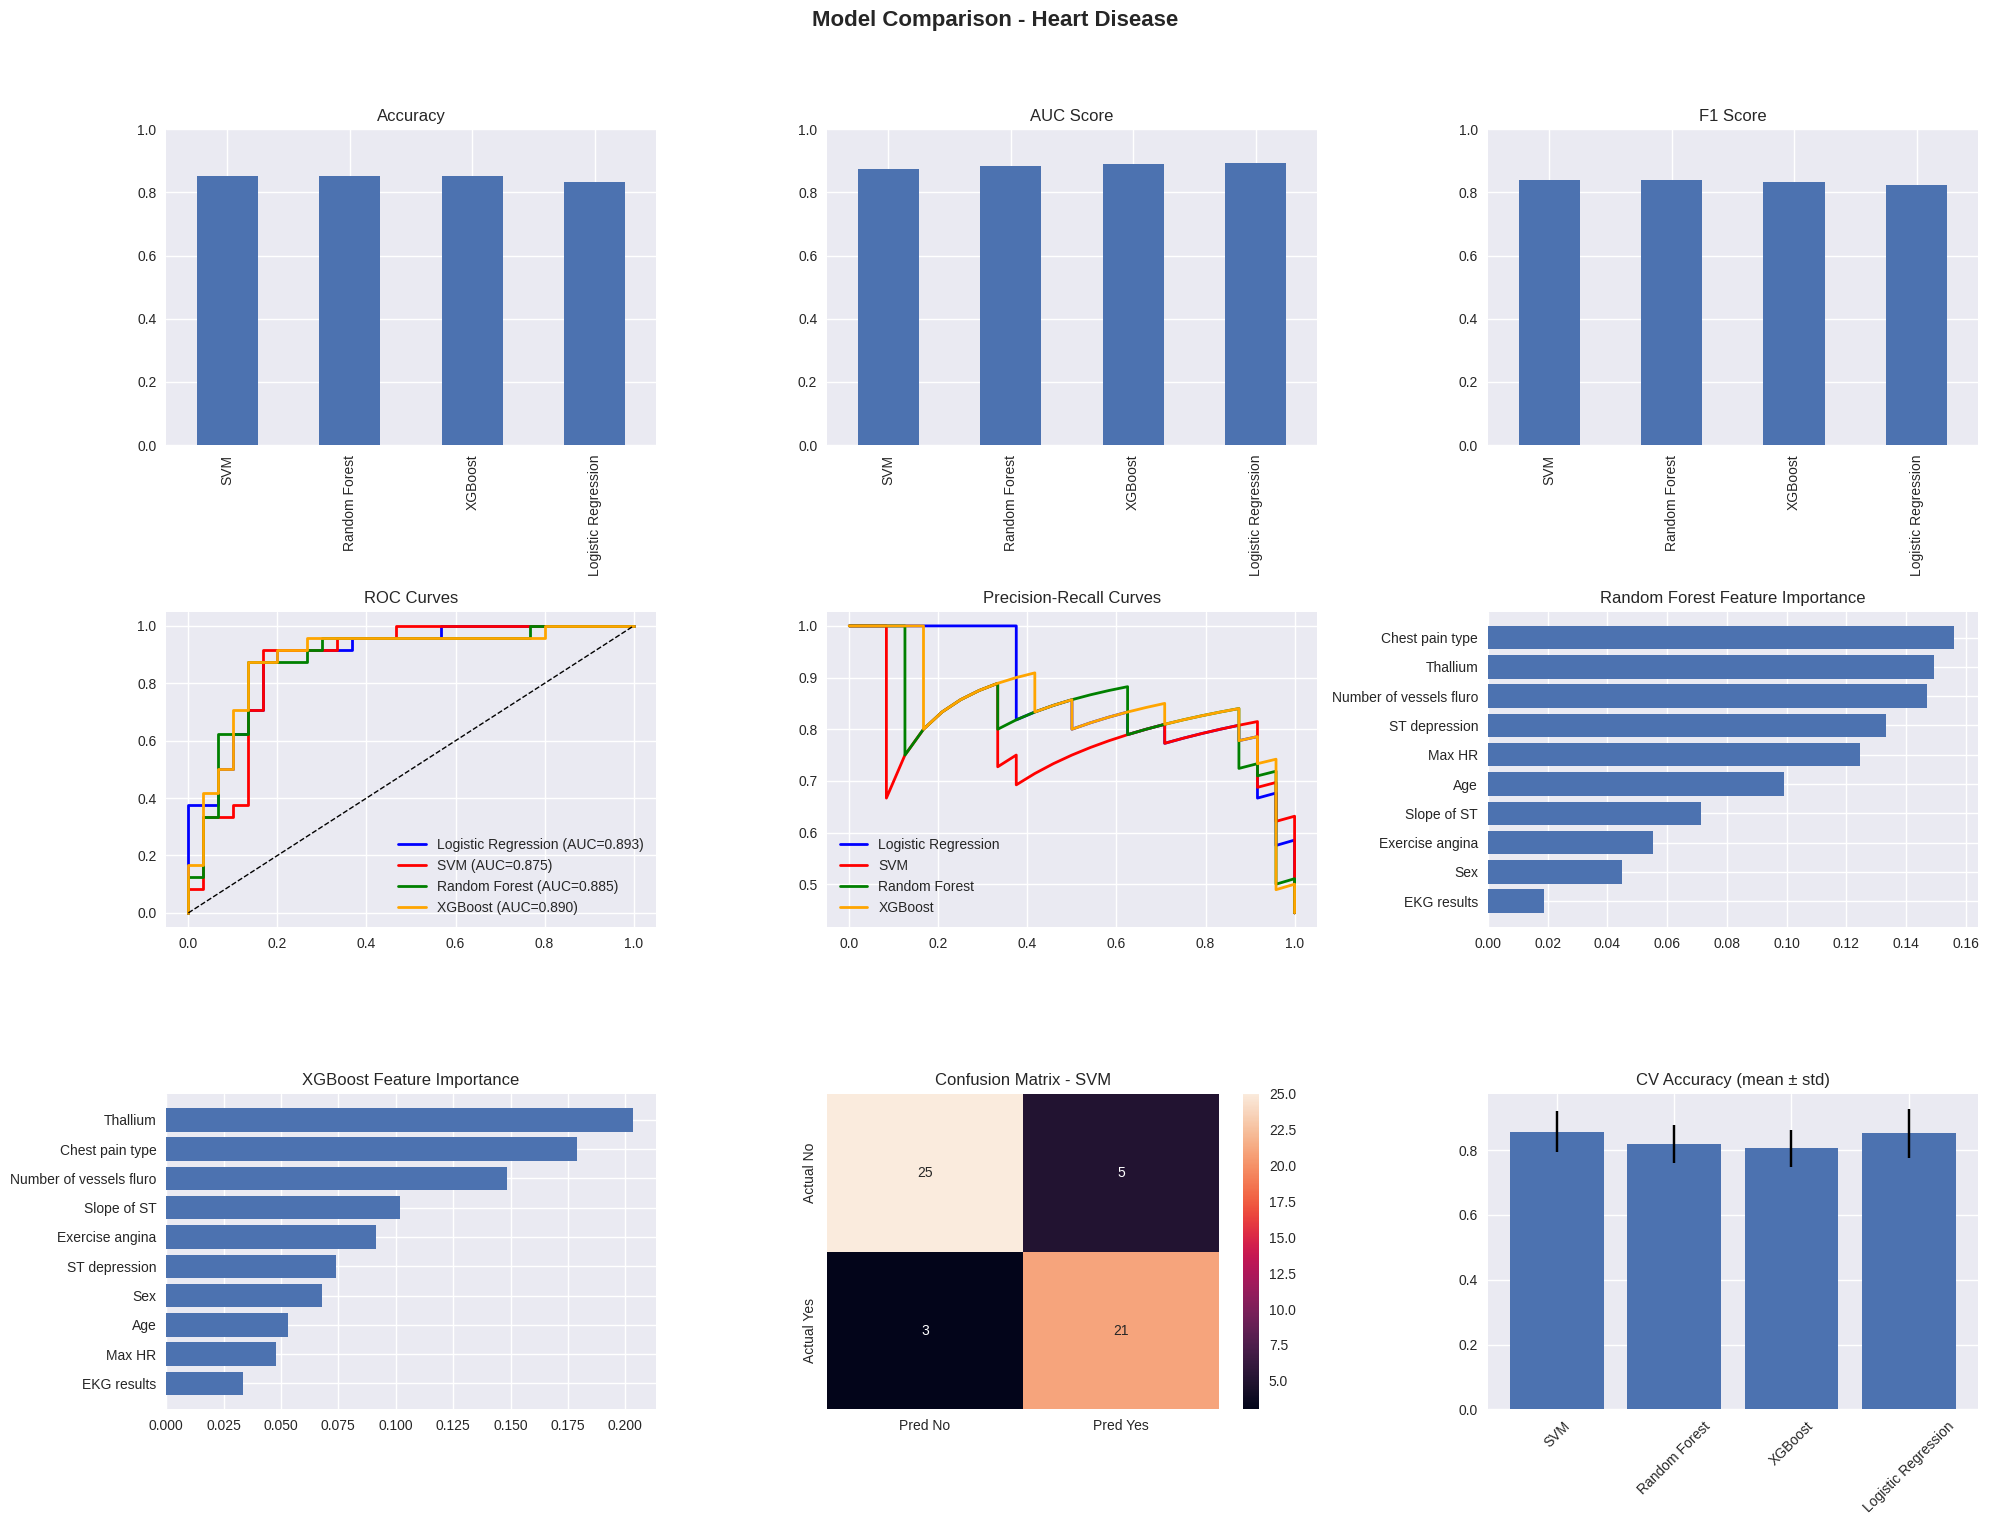

In [60]:
# STEP 14 — Plots: accuracy, AUC, ROC curves, feature importances, confusion matrix
plt.rcParams.update({'figure.max_open_warning': 0})
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('Model Comparison - Heart Disease', fontsize=16, fontweight='bold')

# Accuracy bar
results_df['accuracy'].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Accuracy')
axes[0,0].set_ylim(0,1)

# AUC bar
results_df['auc_score'].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('AUC Score')
axes[0,1].set_ylim(0,1)

# F1 bar
results_df['f1_score'].plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('F1 Score')
axes[0,2].set_ylim(0,1)

# ROC curves
ax = axes[1,0]
colors = ['blue', 'red', 'green', 'orange']
for i, (name, model) in enumerate(best_models.items()):
    try:
        proba = model.predict_proba(X_test_scaled)[:, 1]
    except:
        try:
            df_scores = model.decision_function(X_test_scaled)
            proba = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min() + 1e-9)
        except:
            proba = np.zeros(len(y_test))
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_val = roc_auc_score(y_test, proba) if len(np.unique(y_test))>1 else np.nan
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})", linewidth=2, color=colors[i % len(colors)])
ax.plot([0,1],[0,1],'k--', linewidth=1)
ax.set_title('ROC Curves')
ax.legend()

# Precision-Recall curves
ax = axes[1,1]
for i, (name, model) in enumerate(best_models.items()):
    try:
        proba = model.predict_proba(X_test_scaled)[:, 1]
    except:
        try:
            df_scores = model.decision_function(X_test_scaled)
            proba = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min() + 1e-9)
        except:
            proba = np.zeros(len(y_test))
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ax.plot(recall, precision, label=name, linewidth=2, color=colors[i % len(colors)])
ax.set_title('Precision-Recall Curves')
ax.legend()

# Feature importance from RandomForest (if present)
if 'Random Forest' in best_models:
    rf = best_models['Random Forest']
    importances = pd.Series(rf.feature_importances_, index=selected_features).sort_values()
    axes[1,2].barh(importances.index, importances.values)
    axes[1,2].set_title('Random Forest Feature Importance')

    # XGBoost feature importance
if 'XGBoost' in best_models:
    xgb = best_models['XGBoost']
    try:
        importances_xgb = pd.Series(xgb.feature_importances_, index=selected_features).sort_values()
        axes[2,0].barh(importances_xgb.index, importances_xgb.values)
        axes[2,0].set_title('XGBoost Feature Importance')
    except:
        pass

        # Confusion matrix for best model (by accuracy)
best_name = results_df.index[0]
best_model = best_models[best_name]
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[2,1],
            xticklabels=['Pred No','Pred Yes'], yticklabels=['Actual No','Actual Yes'])
axes[2,1].set_title(f'Confusion Matrix - {best_name}')

# CV means plot
axes[2,2].bar(range(len(results_df)), results_df['cv_mean'], yerr=results_df['cv_std'], capsize=5)
axes[2,2].set_xticks(range(len(results_df)))
axes[2,2].set_xticklabels(results_df.index, rotation=45)
axes[2,2].set_title('CV Accuracy (mean ± std)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()







In [61]:
# STEP 15 — Detailed classification report for best model
print(f"\nBEST MODEL: {best_name}")
print("Classification report:")
print(classification_report(y_test, y_pred_best, target_names=['No Disease', 'Disease']))



BEST MODEL: SVM
Classification report:
              precision    recall  f1-score   support

  No Disease       0.89      0.83      0.86        30
     Disease       0.81      0.88      0.84        24

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



In [62]:
# STEP 16 — Top 5 features from Random Forest (if available)
if 'Random Forest' in best_models:
    rf = best_models['Random Forest']
    fi = pd.Series(rf.feature_importances_, index=selected_features).sort_values(ascending=False)
    print("\nTop 5 features (Random Forest):")
    print(fi.head(5))



Top 5 features (Random Forest):
Chest pain type            0.156220
Thallium                   0.149272
Number of vessels fluro    0.147027
ST depression              0.133237
Max HR                     0.124610
dtype: float64


In [64]:
# STEP 17 — Save artifacts
artifacts = {
    'best_model_name': best_name,
    'best_model': best_models[best_name],
    'all_best_models': best_models,
    'scaler': scaler,
    'feature_selector': selector,
    'selected_features': selected_features,
    'results_df': results_df
}
save_path = '/content/heart_disease_best_model_artifacts.pkl'
joblib.dump(artifacts, save_path)
print(f"\nSaved artifacts to: {save_path}")

print("\nPIPELINE COMPLETE ✅")


Saved artifacts to: /content/heart_disease_best_model_artifacts.pkl

PIPELINE COMPLETE ✅
